In [3]:
%pip install transformers==4.36.0
%pip install torch torchvision torchaudio
%pip install pandas numpy scikit-learn matplotlib seaborn tqdm datasets accelerate

   ---------------------------------------- 0.0/8.2 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.2 MB 3.4 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/8.2 MB 3.4 MB/s eta 0:00:03
   ----------- ---------------------------- 2.4/8.2 MB 3.8 MB/s eta 0:00:02
   --------------- ------------------------ 3.1/8.2 MB 3.9 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.2 MB 4.3 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.2 MB 4.1 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.2 MB 4.1 MB/s eta 0:00:01
   --------------------------------- ------ 6.8/8.2 MB 4.2 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.2 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 8.2/8.2 MB 4.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------- ------------------------------ 0.5/2.2 MB 2.8 MB/s eta 0:00:01
   -----------------------

  You can safely remove it manually.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

c:\Users\ASUS\anaconda3\envs\spacy-env\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\ASUS\anaconda3\envs\spacy-env\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [6]:
np.random.seed(42)
torch.manual_seed(42)

# Check CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [10]:
import os

print(f"Current directory: {os.getcwd()}")

print("\nFiles in data/raw:")
try:
    files_in_raw = os.listdir('data/raw')
    for f in files_in_raw:
        print(f"  - {f}")
except:
    print("  Folder data/raw not found!")

files = [
    '../data/raw/Gojek_Reviews_2021.csv',
    '../data/raw/Gojek_Reviews_2022.csv',
    '../data/raw/Gojek_Reviews_2023.csv',
    '../data/raw/Gojek_Reviews_2024.csv',
    '../data/raw/Gojek_Reviews_2025.csv'
]

dfs = []
for file in files:
    try:
        try:
            df_temp = pd.read_csv(file)
        except UnicodeDecodeError:
            df_temp = pd.read_csv(file, encoding='latin-1')
        except:
            df_temp = pd.read_csv(file, encoding='ISO-8859-1')
        
        dfs.append(df_temp)
        print(f"Loaded {file}: {len(df_temp)} reviews")
    except FileNotFoundError:
        print(f"File not found: {file}")
    except Exception as e:
        print(f"Error loading {file}: {e}")

if len(dfs) == 0:
    print("\nNo CSV files loaded! Please check your file paths.")
    print("\nTips:")
    print("1. Make sure you're running the notebook from the correct directory")
    print("2. Or use absolute path (full path) to your CSV files")
else:
    df = pd.concat(dfs, ignore_index=True)
    print(f"\nSuccessfully loaded {len(dfs)} files")
    print(f"Total reviews: {len(df)}")
    print(f"Columns: {df.columns.tolist()}")
    print("\nFirst 5 rows:")
    print(df.head())

Current directory: c:\Project-Information-Retrieval\notebooks

Files in data/raw:
  Folder data/raw not found!
Loaded ../data/raw/Gojek_Reviews_2021.csv: 69485 reviews
Loaded ../data/raw/Gojek_Reviews_2022.csv: 161736 reviews
Loaded ../data/raw/Gojek_Reviews_2023.csv: 81725 reviews
Loaded ../data/raw/Gojek_Reviews_2024.csv: 76319 reviews
Loaded ../data/raw/Gojek_Reviews_2025.csv: 47235 reviews

Successfully loaded 5 files
Total reviews: 436500
Columns: ['content', 'score', 'at']

First 5 rows:
                                             content  score  \
0                                               Baik      5   
1                                             Mantap      4   
2                                    Sangat membantu      5   
3  My problem have been solved.. thanks.. It shou...      5   
4                                                Top      5   

                    at  
0  2021-12-31 23:49:14  
1  2021-12-31 23:40:15  
2  2021-12-31 23:22:29  
3  2021-12-31 23:21:57

In [11]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [12]:
text_column = 'content'
score_column = 'score'

df['cleaned_text'] = df[text_column].apply(clean_text)
df = df[df['cleaned_text'].str.len() > 0].reset_index(drop=True)

print(f"Data after cleaning: {len(df)} reviews")

Data after cleaning: 436494 reviews


In [13]:
def rating_to_sentiment(rating):
    if pd.isna(rating):
        return None
    rating = int(rating)
    if rating <= 2:
        return 0   
    elif rating == 3:
        return 1   
    else:
        return 2   

df['label'] = df[score_column].apply(rating_to_sentiment)
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)


Label Distribution:
Negatif: 109989 (25.20%)
Netral: 17397 (3.99%)
Positif: 309108 (70.82%)


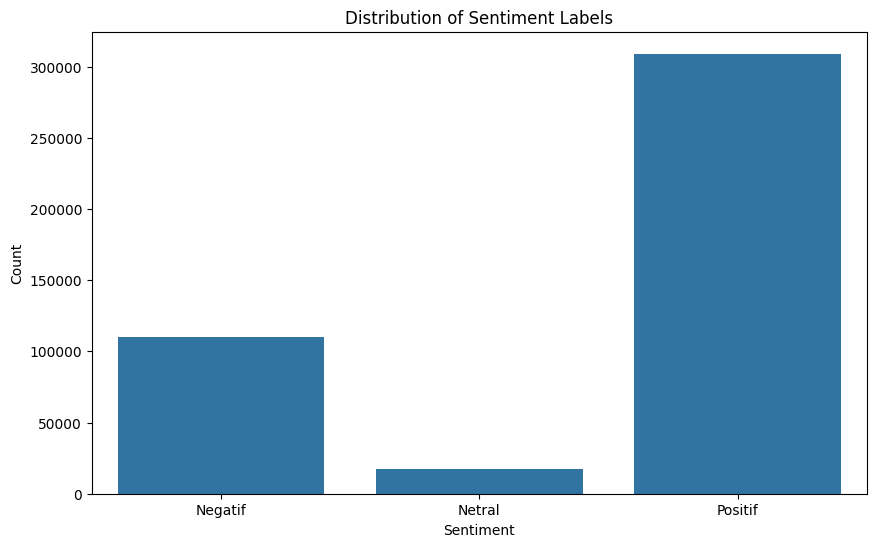

In [14]:
print("\nLabel Distribution:")
for label, count in df['label'].value_counts().sort_index().items():
    sentiment = ['Negatif', 'Netral', 'Positif'][label]
    print(f"{sentiment}: {count} ({count/len(df)*100:.2f}%)")

# Visualize
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label')
plt.xticks([0, 1, 2], ['Negatif', 'Netral', 'Positif'])
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [15]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['cleaned_text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"\nTrain: {len(train_texts)} samples")
print(f"Validation: {len(val_texts)} samples")
print(f"Test: {len(test_texts)} samples")


Train: 349195 samples
Validation: 43649 samples
Test: 43650 samples


In [18]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Using CPU (training will be slower)")

Device: cpu
Using CPU (training will be slower)


In [19]:
model_options = [
    "indolem/indobert-base-uncased",
    "cahya/bert-base-indonesian-1.5G",
    "indobenchmark/indobert-base-p2"
]

model = None
tokenizer = None

for model_name in model_options:
    try:
        print(f"\nTrying model: {model_name}")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=3,
            id2label={0: "Negatif", 1: "Netral", 2: "Positif"},
            label2id={"Negatif": 0, "Netral": 1, "Positif": 2}
        )
        
        model.to(device)
        print(f"Success! Using model: {model_name}")
        break
    except Exception as e:
        print(f"Failed: {e}")
        continue

if model is None:
    print("\nAll models failed to load!")
else:
    print(f"\nModel loaded on {device}")



Trying model: indolem/indobert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Success! Using model: indolem/indobert-base-uncased

Model loaded on cpu


In [20]:
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

print("Tokenizing datasets...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("Tokenization complete")

Tokenizing datasets...


Map:   0%|          | 0/349195 [00:00<?, ? examples/s]

Map:   0%|          | 0/43649 [00:00<?, ? examples/s]

Map:   0%|          | 0/43650 [00:00<?, ? examples/s]

Tokenization complete


In [ ]:
 
sample_percentage = 0.2
sample_size = int(len(df) * sample_percentage)

df_sampled = df.sample(n=sample_size, random_state=42)

print(f"Original data: {len(df)} reviews")
print(f"Sampled data: {len(df_sampled)} reviews ({sample_percentage*100}%)")

# Create labels untuk sampled data
def rating_to_sentiment(rating):
    if pd.isna(rating):
        return None
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df_sampled['label'] = df_sampled[score_column].apply(rating_to_sentiment)
df_sampled = df_sampled.dropna(subset=['label']).reset_index(drop=True)
df_sampled['label'] = df_sampled['label'].astype(int)

print("\nLabel Distribution (Sampled):")
for label, count in df_sampled['label'].value_counts().sort_index().items():
    sentiment = ['Negatif', 'Netral', 'Positif'][label]
    print(f"{sentiment}: {count} ({count/len(df_sampled)*100:.2f}%)")
 
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_sampled['cleaned_text'].tolist(),
    df_sampled['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_sampled['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"\nNew split:")
print(f"Train: {len(train_texts)} samples")
print(f"Validation: {len(val_texts)} samples")
print(f"Test: {len(test_texts)} samples")
 
from datasets import Dataset

train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

print("\nTokenizing sampled datasets...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("Tokenization complete")
 
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import time

model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(
    train_dataset, 
    shuffle=True, 
    batch_size=16,
    collate_fn=data_collator
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=32,
    collate_fn=data_collator
)

num_epochs = 2
gradient_accumulation_steps = 2
best_val_acc = 0.0

print(f"\nDevice: {device}")
print(f"Epochs: {num_epochs}")
print(f"Batch size: {train_dataloader.batch_size}")
print(f"Training batches per epoch: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")

# Estimasi waktu
estimated_seconds = len(train_dataloader) * 1.47 * num_epochs
estimated_hours = estimated_seconds / 3600
print(f"\nEstimated training time: {estimated_hours:.1f} hours ({estimated_hours*60:.0f} minutes)\n")

training_history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"{'='*80}")
    
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(train_dataloader, desc="Training")
    
    for step, batch in enumerate(progress_bar):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)
        loss = outputs.loss / gradient_accumulation_steps
        total_loss += loss.item() * gradient_accumulation_steps
        
        loss.backward()
        
        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
        
        progress_bar.set_postfix({
            'loss': f'{loss.item() * gradient_accumulation_steps:.4f}',
            'avg_loss': f'{total_loss/(step+1):.4f}'
        })
    
    avg_train_loss = total_loss / len(train_dataloader)
    training_history['train_loss'].append(avg_train_loss)
    
    print(f"\nAverage Training Loss: {avg_train_loss:.4f}")
    
    model.eval()
    val_preds = []
    val_labels_list = []
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_val_loss += outputs.loss.item()
            predictions = torch.argmax(outputs.logits, dim=-1)
            val_preds.extend(predictions.cpu().numpy())
            val_labels_list.extend(batch['labels'].cpu().numpy())
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = accuracy_score(val_labels_list, val_preds)
    
    training_history['val_loss'].append(avg_val_loss)
    training_history['val_acc'].append(val_accuracy)
    
    epoch_time = time.time() - epoch_start_time
    
    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Epoch Time: {epoch_time/60:.1f} minutes")
    
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        print("New best validation accuracy. Saving model...")
        output_dir = './models/gojek_sentiment_model_best'
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)

print(f"\n{'='*80}")
print("Training Complete")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

output_dir = './models/gojek_sentiment_model'
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model saved to: {output_dir}")

Original data: 436494 reviews
Sampled data: 87298 reviews (20.0%)

Label Distribution (Sampled):
Negatif: 21848 (25.03%)
Netral: 3475 (3.98%)
Positif: 61975 (70.99%)

New split:
Train: 69838 samples
Validation: 8730 samples
Test: 8730 samples

Tokenizing sampled datasets...


Map:   0%|          | 0/69838 [00:00<?, ? examples/s]

Map:   0%|          | 0/8730 [00:00<?, ? examples/s]

Map:   0%|          | 0/8730 [00:00<?, ? examples/s]

Tokenization complete

Device: cpu
Epochs: 2
Batch size: 16
Training batches per epoch: 4365
Validation batches: 273

Estimated training time: 3.6 hours (214 minutes)


Epoch 1/2


Training: 100%|██████████| 4365/4365 [2:21:29<00:00,  1.94s/it, loss=0.3835, avg_loss=0.3264]  



Average Training Loss: 0.3264


Validation: 100%|██████████| 273/273 [05:13<00:00,  1.15s/it]


Average Validation Loss: 0.3045
Validation Accuracy: 0.9021
Epoch Time: 146.7 minutes
New best validation accuracy. Saving model...

Epoch 2/2


Training: 100%|██████████| 4365/4365 [2:23:14<00:00,  1.97s/it, loss=0.6293, avg_loss=0.2891]  



Average Training Loss: 0.2891


Validation: 100%|██████████| 273/273 [04:52<00:00,  1.07s/it]


Average Validation Loss: 0.2964
Validation Accuracy: 0.9027
Epoch Time: 148.1 minutes
New best validation accuracy. Saving model...

Training Complete
Best Validation Accuracy: 0.9027
Model saved to: ./models/gojek_sentiment_model


In [26]:
def batch_predict(texts, model, tokenizer, device, batch_size=32):
    predictions = []
    model.eval()
    
    from tqdm import tqdm
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
        batch_texts = texts[i:i+batch_size]
        cleaned_texts = [clean_text(text) for text in batch_texts]
        
        inputs = tokenizer(cleaned_texts, return_tensors='pt', 
                          truncation=True, max_length=128, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_classes = torch.argmax(probs, dim=-1)
            confidences = torch.max(probs, dim=-1).values
        
        for pred, conf in zip(predicted_classes.cpu().numpy(), confidences.cpu().numpy()):
            predictions.append({
                'predicted_label': int(pred),
                'confidence': float(conf)
            })
    
    return predictions

all_predictions = batch_predict(df['cleaned_text'].tolist(), model, tokenizer, device, batch_size=32)

df['predicted_label'] = [p['predicted_label'] for p in all_predictions]
df['prediction_confidence'] = [p['confidence'] for p in all_predictions]
df['predicted_sentiment'] = df['predicted_label'].map({
    0: 'Negatif', 1: 'Netral', 2: 'Positif'
})

from datetime import datetime

output_folder = 'sentiment_results'
os.makedirs(output_folder, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

output_file_all = f'{output_folder}/gojek_reviews_labeled_{timestamp}.csv'
df.to_csv(output_file_all, index=False, encoding='utf-8-sig')

high_conf = df[df['prediction_confidence'] > 0.8]
output_file_high = f'{output_folder}/gojek_reviews_high_confidence_{timestamp}.csv'
high_conf.to_csv(output_file_high, index=False, encoding='utf-8-sig')

for sentiment_label, sentiment_name in [(0, 'negative'), (1, 'neutral'), (2, 'positive')]:
    df_sentiment = df[df['predicted_label'] == sentiment_label]
    output_file = f'{output_folder}/gojek_reviews_{sentiment_name}_{timestamp}.csv'
    df_sentiment.to_csv(output_file, index=False, encoding='utf-8-sig')

summary_stats = {
    'Total Reviews': len(df),
    'Negative': len(df[df['predicted_label'] == 0]),
    'Neutral': len(df[df['predicted_label'] == 1]),
    'Positive': len(df[df['predicted_label'] == 2]),
    'Negative %': f"{len(df[df['predicted_label'] == 0])/len(df)*100:.2f}%",
    'Neutral %': f"{len(df[df['predicted_label'] == 1])/len(df)*100:.2f}%",
    'Positive %': f"{len(df[df['predicted_label'] == 2])/len(df)*100:.2f}%",
    'Test Accuracy': f"{test_accuracy:.4f}",
    'Avg Confidence': f"{df['prediction_confidence'].mean():.2%}"
}

summary_df = pd.DataFrame([summary_stats]).T
summary_df.columns = ['Value']
summary_file = f'{output_folder}/summary_{timestamp}.csv'
summary_df.to_csv(summary_file, encoding='utf-8-sig')

print(f"Done. Results saved in: {output_folder}/")

Predicting: 100%|██████████| 13641/13641 [2:23:09<00:00,  1.59it/s]  


NameError: name 'test_accuracy' is not defined